In [846]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [847]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [848]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2407060 entries, 0 to 2407059
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 36.7 MB


# reduce to 1 million events

In [849]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion millisec -> sec

In [850]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,21188,0.17,21.188
1,21274,0.17,21.274
2,20639,0.17,20.639
3,25678,0.14,25.678
4,33560,0.11,33.560
...,...,...,...
999995,27852,0.13,27.852
999996,27624,0.13,27.624
999997,27812,0.13,27.812
999998,28047,0.13,28.047


### conversion Interval -> kWh

In [851]:
conso_data['Wh']=3600000/conso_data['Interval']
conso_data


,Interval,kWh,sec,Wh
0,21188,0.17,21.188,169.907495
1,21274,0.17,21.274,169.220645
2,20639,0.17,20.639,174.427056
3,25678,0.14,25.678,140.197835
4,33560,0.11,33.560,107.270560
...,...,...,...,...
999995,27852,0.13,27.852,129.254632
999996,27624,0.13,27.624,130.321460
999997,27812,0.13,27.812,129.440529
999998,28047,0.13,28.047,128.355974


### Cumul Total interval

In [852]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [853]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

27158225649000

### Calcul de la date de base = now - cumul_interval

In [854]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 9, 8, 3, 53, 48, 647341)

In [855]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [856]:
conso_data.iloc[0]


Interval     21188.000000
kWh              0.170000
sec             21.188000
Wh             169.907495
cumul(ms)    21188.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [857]:
base

datetime.datetime(2024, 9, 8, 3, 53, 48, 647341)

## créer les dates

In [858]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-09-08 03:54:09.835341
1        2024-09-08 03:54:31.109341
2        2024-09-08 03:54:51.748341
3        2024-09-08 03:55:17.426341
4        2024-09-08 03:55:50.986341
                    ...            
999995   2025-07-19 11:49:02.224341
999996   2025-07-19 11:49:29.848341
999997   2025-07-19 11:49:57.660341
999998   2025-07-19 11:50:25.707341
999999   2025-07-19 11:50:54.296341
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [859]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,21188,0.17,21.188,169.907495,21188,2024-09-08 03:54:09.835341,08/09/24
1,21274,0.17,21.274,169.220645,42462,2024-09-08 03:54:31.109341,08/09/24
2,20639,0.17,20.639,174.427056,63101,2024-09-08 03:54:51.748341,08/09/24
3,25678,0.14,25.678,140.197835,88779,2024-09-08 03:55:17.426341,08/09/24
4,33560,0.11,33.560,107.270560,122339,2024-09-08 03:55:50.986341,08/09/24
...,...,...,...,...,...,...,...
999995,27852,0.13,27.852,129.254632,27158113577,2025-07-19 11:49:02.224341,19/07/25
999996,27624,0.13,27.624,130.321460,27158141201,2025-07-19 11:49:29.848341,19/07/25
999997,27812,0.13,27.812,129.440529,27158169013,2025-07-19 11:49:57.660341,19/07/25
999998,28047,0.13,28.047,128.355974,27158197060,2025-07-19 11:50:25.707341,19/07/25


### save conso_data with dates

In [860]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [861]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
here = now.strftime('%H:%M:%S')
today, date, month, year, here

('19/07/25', 19, 7, 2025, '11:51:13')

In [862]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [863]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1340 entries, 998660 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1340 non-null   int64         
 1   kWh        1340 non-null   float64       
 2   sec        1340 non-null   float64       
 3   Wh         1340 non-null   float64       
 4   cumul(ms)  1340 non-null   int64         
 5   dates      1340 non-null   datetime64[ns]
 6   days       1340 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 83.8+ KB


In [864]:
end = time.time()
print(end - start)

25.97541356086731


### grouped by days

In [865]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [866]:
data = list(df_grp['kWh'])
print(data)

[2.701, 2.618, 1.799, 1.791, 1.796, 1.794, 2.41, 1.927, 1.788, 1.793, 1.788, 1.819, 1.82, 1.818, 1.814, 1.818, 1.817, 1.815, 1.819, 1.783, 1.788, 1.784, 1.785, 1.783, 1.798, 1.788, 1.791, 1.784, 1.793, 1.801, 1.798, 1.799, 1.801, 1.785, 1.787, 1.788, 1.788, 1.798, 1.791, 1.799, 1.804, 1.793, 1.802, 1.798, 2.638, 4.0, 3.68, 3.896, 3.092, 3.345, 4.143, 3.349, 3.519, 3.986, 3.322, 3.733, 3.57, 3.98, 3.204, 3.315, 3.389, 4.093, 3.289, 3.392, 3.814, 3.231, 3.542, 3.292, 3.915, 3.356, 3.416, 3.753, 4.41, 3.602, 3.856, 3.371, 4.226, 3.496, 3.449, 3.281, 3.861, 3.687, 4.116, 3.213, 3.728, 3.809, 3.154, 3.686, 3.648, 3.39, 3.882, 3.191, 4.06, 3.453, 3.697, 4.078, 3.404, 4.537, 3.266, 3.456, 3.117, 3.222, 3.426, 3.352, 3.423, 3.424, 4.597, 4.553, 3.227, 3.452, 3.637, 3.926, 3.55, 4.458, 4.177, 4.083, 3.785, 3.722, 3.563, 3.537, 4.388, 3.164, 3.38, 3.402, 3.449, 3.611, 3.376, 4.552, 3.262, 3.787, 3.249, 3.599, 3.546, 3.289, 3.989, 3.283, 4.669, 3.943, 3.312, 4.434, 3.509, 4.786, 3.81, 3.081, 3.23

In [867]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [868]:
end = time.time()
print(end - start)

26.887959241867065


### plot function by day
#### show('dd/mm/yy')

In [869]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


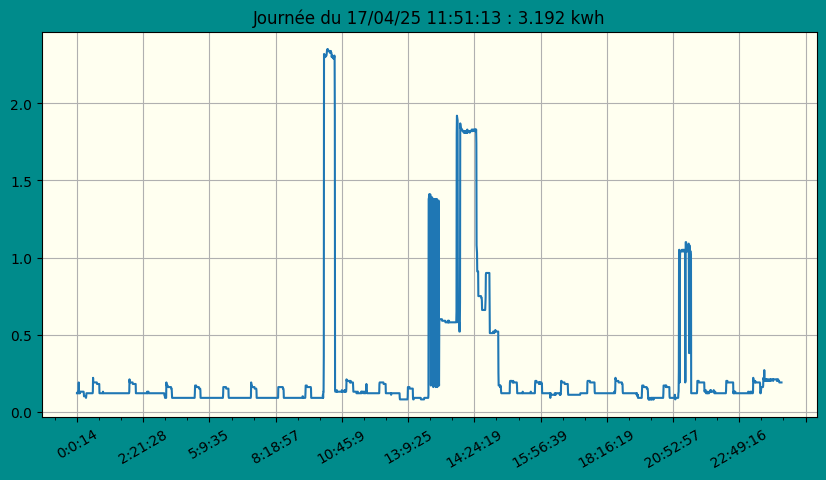

In [870]:
show('17/04/25')

In [871]:
end = time.time()
print(end - start)

28.59528136253357


### 1 kWh window in data of one day
#### df = conso_day

In [872]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998660,29488,0.12,29.488,122.083559,27115575294,2025-07-19 00:00:03.941341,19/07/25
998661,29730,0.12,29.730,121.089808,27115605024,2025-07-19 00:00:33.671341,19/07/25
998662,28764,0.12,28.764,125.156446,27115633788,2025-07-19 00:01:02.435341,19/07/25
998663,27759,0.13,27.759,129.687669,27115661547,2025-07-19 00:01:30.194341,19/07/25
998664,28308,0.13,28.308,127.172531,27115689855,2025-07-19 00:01:58.502341,19/07/25
...,...,...,...,...,...,...,...
999995,27852,0.13,27.852,129.254632,27158113577,2025-07-19 11:49:02.224341,19/07/25
999996,27624,0.13,27.624,130.321460,27158141201,2025-07-19 11:49:29.848341,19/07/25
999997,27812,0.13,27.812,129.440529,27158169013,2025-07-19 11:49:57.660341,19/07/25
999998,28047,0.13,28.047,128.355974,27158197060,2025-07-19 11:50:25.707341,19/07/25


In [873]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [874]:
df = conso_day
len(df)

1340

In [875]:
period()  # first kWh
if len(df)>1000:
    period(p=2) # second period

2025-07-19 00:00:03.941341	2025-07-19 09:19:21.135341	9h 19m 17s 	1000
2025-07-19 09:19:21.135341	2025-07-19 11:50:54.296341	2h 31m 33s 	340


In [876]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.301304
dtype: float64

In [877]:
end = time.time()
print(end - start)

29.026280164718628


## mean for data grouped by days

In [878]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.174603
dtype: float64

In [879]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(1.34)

# conso by date


In [880]:
# select day
day = today

#day = '16/08/24'
day

'19/07/25'

In [881]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998660,29488,0.12,29.488,122.083559,27115575294,2025-07-19 00:00:03.941341,19/07/25
998661,29730,0.12,29.730,121.089808,27115605024,2025-07-19 00:00:33.671341,19/07/25
998662,28764,0.12,28.764,125.156446,27115633788,2025-07-19 00:01:02.435341,19/07/25
998663,27759,0.13,27.759,129.687669,27115661547,2025-07-19 00:01:30.194341,19/07/25
998664,28308,0.13,28.308,127.172531,27115689855,2025-07-19 00:01:58.502341,19/07/25
...,...,...,...,...,...,...,...
999995,27852,0.13,27.852,129.254632,27158113577,2025-07-19 11:49:02.224341,19/07/25
999996,27624,0.13,27.624,130.321460,27158141201,2025-07-19 11:49:29.848341,19/07/25
999997,27812,0.13,27.812,129.440529,27158169013,2025-07-19 11:49:57.660341,19/07/25
999998,28047,0.13,28.047,128.355974,27158197060,2025-07-19 11:50:25.707341,19/07/25


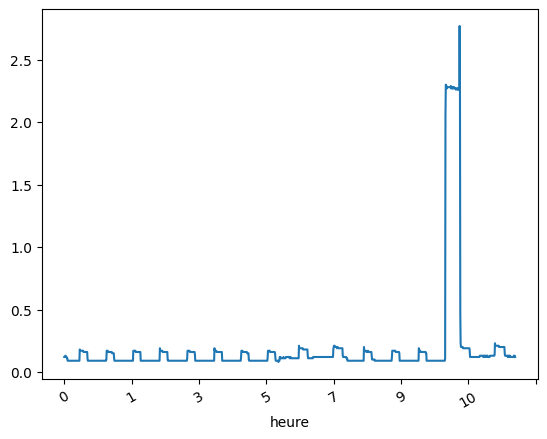

In [882]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df3= conso_day.set_index('heure')
df3.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [883]:
end = time.time()
print(end - start)

29.958812952041626


### grouped by 'heure'

In [884]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1340 entries, 998660 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1340 non-null   int64         
 1   kWh        1340 non-null   float64       
 2   sec        1340 non-null   float64       
 3   Wh         1340 non-null   float64       
 4   cumul(ms)  1340 non-null   int64         
 5   dates      1340 non-null   datetime64[ns]
 6   days       1340 non-null   object        
 7   heure      1340 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 94.2+ KB


In [885]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998660,29488,0.12,29.488,122.083559,27115575294,2025-07-19 00:00:03.941341,19/07/25
998661,29730,0.12,29.730,121.089808,27115605024,2025-07-19 00:00:33.671341,19/07/25
998662,28764,0.12,28.764,125.156446,27115633788,2025-07-19 00:01:02.435341,19/07/25
998663,27759,0.13,27.759,129.687669,27115661547,2025-07-19 00:01:30.194341,19/07/25
998664,28308,0.13,28.308,127.172531,27115689855,2025-07-19 00:01:58.502341,19/07/25
...,...,...,...,...,...,...,...
999995,27852,0.13,27.852,129.254632,27158113577,2025-07-19 11:49:02.224341,19/07/25
999996,27624,0.13,27.624,130.321460,27158141201,2025-07-19 11:49:29.848341,19/07/25
999997,27812,0.13,27.812,129.440529,27158169013,2025-07-19 11:49:57.660341,19/07/25
999998,28047,0.13,28.047,128.355974,27158197060,2025-07-19 11:50:25.707341,19/07/25


In [886]:
# group by hour, df  = data of a chosen day
df_byhour = df3[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [887]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0     103
1      98
2     109
3      99
4      99
5     100
6     125
7     124
8     103
9     105
10    156
11    119
Name: kWh, dtype: int64

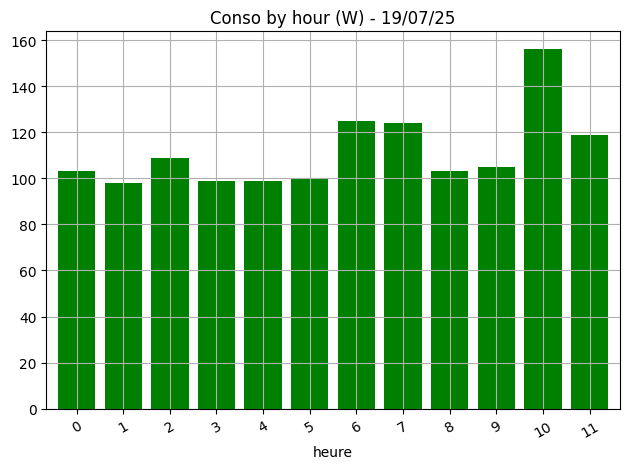

In [888]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [889]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 315 entries, 08/09/24 to 19/07/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     315 non-null    float64
dtypes: float64(1)
memory usage: 4.9+ KB


In [890]:
# give the periods of 1 kwh in a day
period()

2025-07-19 00:00:03.941341	2025-07-19 09:19:21.135341	9h 19m 17s 	1000


In [891]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
    df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


In [892]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [893]:
df_grp.mean()


kWh    3.174603
dtype: float64

In [894]:
df_grp.head()


,kWh
days,
08/09/24,2.701
09/09/24,2.618
10/09/24,1.799
11/09/24,1.791
12/09/24,1.796


In [895]:
df_grp.tail()


,kWh
days,
15/07/25,3.553
16/07/25,3.021
17/07/25,3.322
18/07/25,2.894
19/07/25,1.340


In [896]:
end = time.time()
print(end - start)

31.06225848197937


# plot les 100 derniers jours


In [897]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    2.99687
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

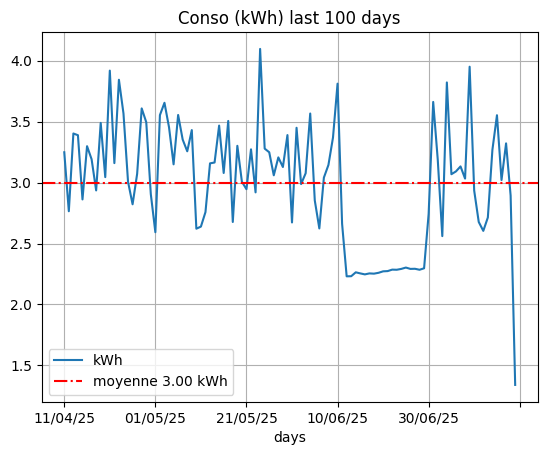

In [898]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.axhline(y=np.nanmean(df_100),c='red', ls='-.',label=f'moyenne {np.nanmean(df_100):.2f} kWh')
plt.grid()
plt.legend()
plt.title('Conso (kWh) last 100 days')


In [899]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,1.340
max,4.097


In [900]:
end = time.time()
print(end - start)

31.58743643760681


In [901]:
df_grp[-31:-1].index[0],df_grp[-31:-1].index[-5]

('19/06/25', '14/07/25')

In [902]:
moyenne = df_grp.iloc[-31:-1].mean()
moyenne

kWh    2.812767
dtype: float64

Text(0.5, 1.0, 'Last month conso by day')

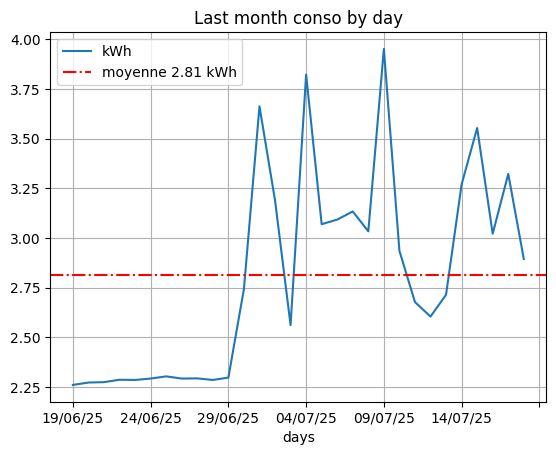

In [903]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.axhline(y=np.nanmean(df_grp.iloc[-31:-1]),c='red', ls='-.',label=f'moyenne {np.nanmean(df_grp.iloc[-31:-1]):.2f} kWh')  
plt.legend()
plt.grid()
plt.title('Last month conso by day')


In [904]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 09/07/25 3.951
Min : 19/06/25 2.26


# Temps de conso par tranche de 1 kWh

In [905]:
def show_tranches():    # temps de conso par tranches de 1kwh
    tranches = len(df)//1000
    print(tranches+1)
    for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
        if len(df)>(p-1)*1000:
            period(p=p)

show_tranches()


2
2025-07-19 00:00:03.941341	2025-07-19 09:19:21.135341	9h 19m 17s 	1000
2025-07-19 09:19:21.135341	2025-07-19 11:50:54.296341	2h 31m 33s 	340


In [906]:
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


('11:51:13', 1.34, 1340)

In [907]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1340 entries, 998660 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1340 non-null   int64         
 1   kWh        1340 non-null   float64       
 2   sec        1340 non-null   float64       
 3   Wh         1340 non-null   float64       
 4   cumul(ms)  1340 non-null   int64         
 5   dates      1340 non-null   datetime64[ns]
 6   days       1340 non-null   object        
 7   heure      1340 non-null   object        
 8   hours      1340 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 104.7+ KB


In [908]:
conso_hours['heure'], conso_hours['hours']

(998660     0
 998661     0
 998662     0
 998663     0
 998664     0
           ..
 999995    11
 999996    11
 999997    11
 999998    11
 999999    11
 Name: heure, Length: 1340, dtype: object,
 998660    00
 998661    00
 998662    00
 998663    00
 998664    00
           ..
 999995    11
 999996    11
 999997    11
 999998    11
 999999    11
 Name: hours, Length: 1340, dtype: object)

In [909]:
end = time.time()
print(end - start)

32.730679512023926


# select number of days to display


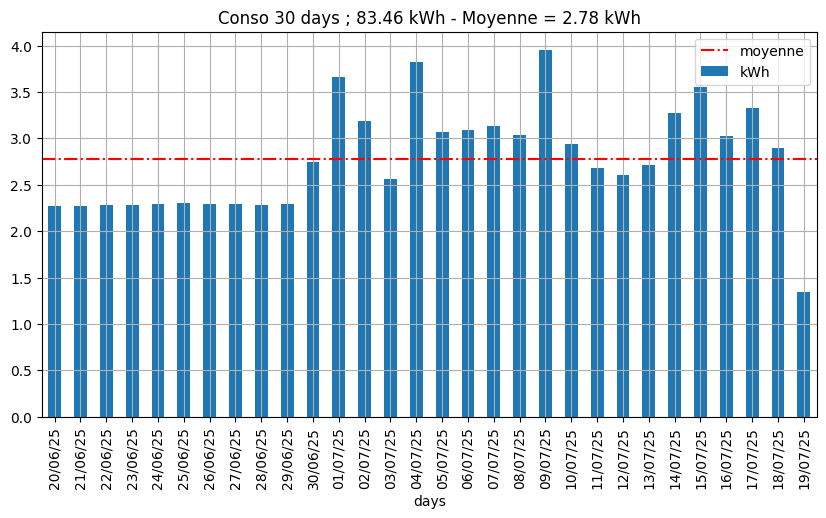

In [910]:
span = 30
conso_mois = round(df_grp.tail(span)['kWh'].sum(),2)

# Plot the figure without labels
moy = round(np.nanmean(df_grp.tail(span)),2)
#conso_mois = sum(df_grp.tail(span)['kWh'])
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight')
 
plt.title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
plt.xticks(rotation=90);


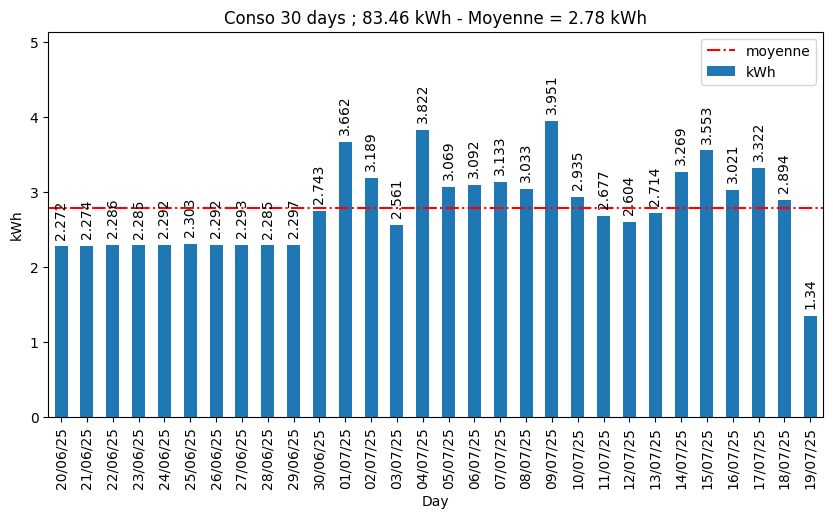

In [911]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
#ax.set_title(f"Conso by {span} days")
ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [912]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
20/06/25    2.272
21/06/25    2.274
22/06/25    2.286
23/06/25    2.285
24/06/25    2.292
25/06/25    2.303
26/06/25    2.292
27/06/25    2.293
28/06/25    2.285
29/06/25    2.297
30/06/25    2.743
01/07/25    3.662
02/07/25    3.189
03/07/25    2.561
04/07/25    3.822
05/07/25    3.069
06/07/25    3.092
07/07/25    3.133
08/07/25    3.033
09/07/25    3.951
10/07/25    2.935
11/07/25    2.677
12/07/25    2.604
13/07/25    2.714
14/07/25    3.269
15/07/25    3.553
16/07/25    3.021
17/07/25    3.322
18/07/25    2.894
19/07/25    1.340
Name: kWh, dtype: float64

In [913]:
x_labels=df_grp.tail(span).index
x_labels

Index(['20/06/25', '21/06/25', '22/06/25', '23/06/25', '24/06/25', '25/06/25',
       '26/06/25', '27/06/25', '28/06/25', '29/06/25', '30/06/25', '01/07/25',
       '02/07/25', '03/07/25', '04/07/25', '05/07/25', '06/07/25', '07/07/25',
       '08/07/25', '09/07/25', '10/07/25', '11/07/25', '12/07/25', '13/07/25',
       '14/07/25', '15/07/25', '16/07/25', '17/07/25', '18/07/25', '19/07/25'],
      dtype='object', name='days')

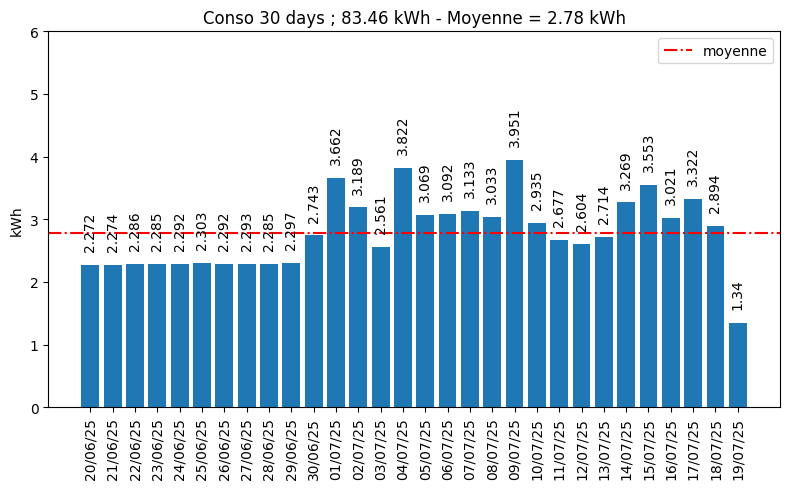

In [914]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
#ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
ax.set(ylabel='kWh', title=f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh', ylim=(0, 6))
plt.xticks(rotation=90);


In [915]:
end = time.time()
print(end - start)

36.30682182312012


In [916]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

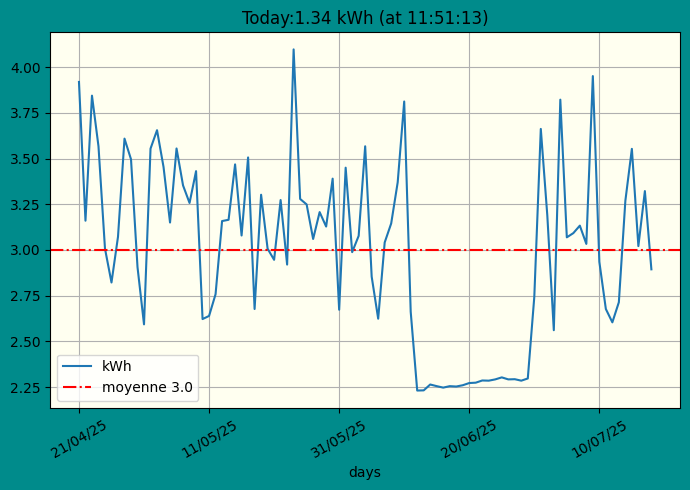

In [917]:
# 3 last months
scan = 90
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

moy = round(np.nanmean(df_grp.iloc[-scan:-1]),2)
df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(f'Today:{last} kWh (at {here})')
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

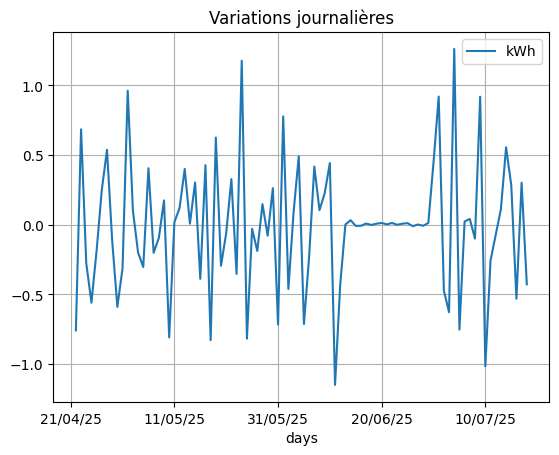

In [918]:
# variations journalières sur 60 jours
df_grp.iloc[-scan:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [919]:
end = time.time()
print(end - start)

37.23140072822571


# Data from 21/08/23

In [920]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,21188,0.17,21.188,169.907495,21188,2024-09-08 03:54:09.835341,08/09/24,03,2024-09,08
1,21274,0.17,21.274,169.220645,42462,2024-09-08 03:54:31.109341,08/09/24,03,2024-09,08
2,20639,0.17,20.639,174.427056,63101,2024-09-08 03:54:51.748341,08/09/24,03,2024-09,08
3,25678,0.14,25.678,140.197835,88779,2024-09-08 03:55:17.426341,08/09/24,03,2024-09,08
4,33560,0.11,33.560,107.270560,122339,2024-09-08 03:55:50.986341,08/09/24,03,2024-09,08
...,...,...,...,...,...,...,...,...,...,...
999995,27852,0.13,27.852,129.254632,27158113577,2025-07-19 11:49:02.224341,19/07/25,11,2025-07,19
999996,27624,0.13,27.624,130.321460,27158141201,2025-07-19 11:49:29.848341,19/07/25,11,2025-07,19
999997,27812,0.13,27.812,129.440529,27158169013,2025-07-19 11:49:57.660341,19/07/25,11,2025-07,19
999998,28047,0.13,28.047,128.355974,27158197060,2025-07-19 11:50:25.707341,19/07/25,11,2025-07,19


In [921]:
end = time.time()
print(end - start)

79.99861407279968


In [922]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07'])

# define month to show

Text(0.5, 1.0, 'Conso by day (W) (2025-04)')

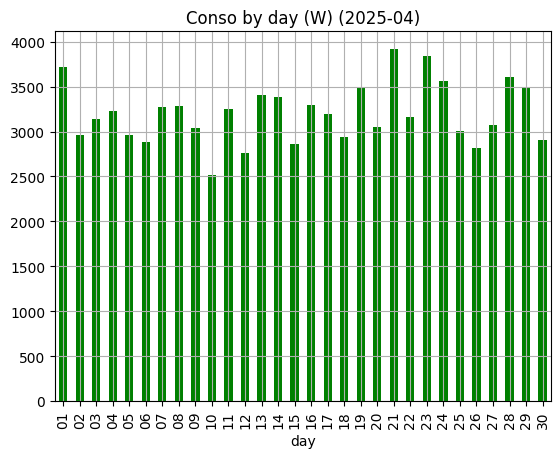

In [923]:
m = '2025-04'
month=conso_grouped_by_month.get_group(m)
conso_grouped_by_month_day = month.groupby(['day'], sort=False)
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)
plt.title(f'Conso by day (W) ({m})')

In [924]:
c=conso_grouped_by_month_day['hours'].count()
c.mean()


np.float64(3200.4666666666667)

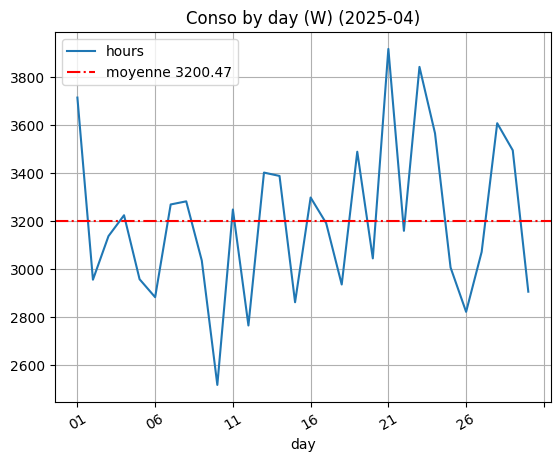

In [925]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
moy = round(c.mean(),2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (W) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);


In [926]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

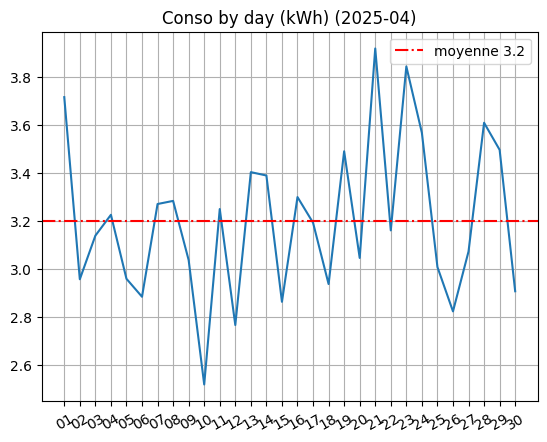

In [927]:
plt.plot(conso_grouped_by_month_day['kWh'].count()/1000)
plt.grid()
moy = round(c.mean()/1000,2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (kWh) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);

In [928]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [929]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [930]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-09,43885,43885,43885
2024-10,73317,73317,73317
2024-11,108174,108174,108174
2024-12,113980,113980,113980
2025-01,113883,113883,113883
2025-02,104273,104273,104273
2025-03,111819,111819,111819
2025-04,96014,96014,96014
2025-05,98605,98605,98605


In [931]:
# example groupby with apply
df2 = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df2.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [932]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [933]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
08/09/24,2701
09/09/24,2618
10/09/24,1799
11/09/24,1791
12/09/24,1796
...,...
15/07/25,3553
16/07/25,3021
17/07/25,3322


In [934]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,21188,0.17,21.188,169.907495,21188,2024-09-08 03:54:09.835341,08/09/24,03,2024-09,08
1,21274,0.17,21.274,169.220645,42462,2024-09-08 03:54:31.109341,08/09/24,03,2024-09,08
2,20639,0.17,20.639,174.427056,63101,2024-09-08 03:54:51.748341,08/09/24,03,2024-09,08
3,25678,0.14,25.678,140.197835,88779,2024-09-08 03:55:17.426341,08/09/24,03,2024-09,08
4,33560,0.11,33.560,107.270560,122339,2024-09-08 03:55:50.986341,08/09/24,03,2024-09,08
...,...,...,...,...,...,...,...,...,...,...
999995,27852,0.13,27.852,129.254632,27158113577,2025-07-19 11:49:02.224341,19/07/25,11,2025-07,19
999996,27624,0.13,27.624,130.321460,27158141201,2025-07-19 11:49:29.848341,19/07/25,11,2025-07,19
999997,27812,0.13,27.812,129.440529,27158169013,2025-07-19 11:49:57.660341,19/07/25,11,2025-07,19
999998,28047,0.13,28.047,128.355974,27158197060,2025-07-19 11:50:25.707341,19/07/25,11,2025-07,19


In [935]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
08/09/24 03    0       08/09/24    03  0.17
               1       08/09/24    03  0.17
               2       08/09/24    03  0.17
               3       08/09/24    03  0.14
               4       08/09/24    03  0.11
...                         ...   ...   ...
19/07/25 11    999995  19/07/25    11  0.13
               999996  19/07/25    11  0.13
               999997  19/07/25    11  0.13
               999998  19/07/25    11  0.13
               999999  19/07/25    11  0.12

[1000000 rows x 3 columns]

In [936]:
groupallbyday.indices.keys()

dict_keys(['08/09/24', '09/09/24', '10/09/24', '11/09/24', '12/09/24', '13/09/24', '14/09/24', '15/09/24', '16/09/24', '17/09/24', '18/09/24', '19/09/24', '20/09/24', '21/09/24', '22/09/24', '23/09/24', '24/09/24', '25/09/24', '26/09/24', '27/09/24', '28/09/24', '29/09/24', '30/09/24', '01/10/24', '02/10/24', '03/10/24', '04/10/24', '05/10/24', '06/10/24', '07/10/24', '08/10/24', '09/10/24', '10/10/24', '11/10/24', '12/10/24', '13/10/24', '14/10/24', '15/10/24', '16/10/24', '17/10/24', '18/10/24', '19/10/24', '20/10/24', '21/10/24', '22/10/24', '23/10/24', '24/10/24', '25/10/24', '26/10/24', '27/10/24', '28/10/24', '29/10/24', '30/10/24', '31/10/24', '01/11/24', '02/11/24', '03/11/24', '04/11/24', '05/11/24', '06/11/24', '07/11/24', '08/11/24', '09/11/24', '10/11/24', '11/11/24', '12/11/24', '13/11/24', '14/11/24', '15/11/24', '16/11/24', '17/11/24', '18/11/24', '19/11/24', '20/11/24', '21/11/24', '22/11/24', '23/11/24', '24/11/24', '25/11/24', '26/11/24', '27/11/24', '28/11/24', '29/1

In [937]:
groupallbydayhours.indices.keys()

dict_keys([('08/09/24', '03'), ('08/09/24', '04'), ('08/09/24', '05'), ('08/09/24', '06'), ('08/09/24', '07'), ('08/09/24', '08'), ('08/09/24', '09'), ('08/09/24', '10'), ('08/09/24', '11'), ('08/09/24', '12'), ('08/09/24', '13'), ('08/09/24', '14'), ('08/09/24', '15'), ('08/09/24', '16'), ('08/09/24', '17'), ('08/09/24', '18'), ('08/09/24', '19'), ('08/09/24', '20'), ('08/09/24', '21'), ('08/09/24', '22'), ('08/09/24', '23'), ('09/09/24', '03'), ('09/09/24', '04'), ('09/09/24', '05'), ('09/09/24', '06'), ('09/09/24', '07'), ('09/09/24', '08'), ('09/09/24', '09'), ('09/09/24', '10'), ('09/09/24', '11'), ('09/09/24', '12'), ('09/09/24', '13'), ('09/09/24', '14'), ('09/09/24', '15'), ('09/09/24', '16'), ('09/09/24', '17'), ('09/09/24', '18'), ('09/09/24', '19'), ('09/09/24', '20'), ('09/09/24', '21'), ('09/09/24', '22'), ('09/09/24', '23'), ('09/09/24', '00'), ('09/09/24', '01'), ('09/09/24', '02'), ('10/09/24', '03'), ('10/09/24', '04'), ('10/09/24', '05'), ('10/09/24', '06'), ('10/09/2

In [938]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
08/09/24,2701,2701
09/09/24,2618,2618
10/09/24,1799,1799
11/09/24,1791,1791
12/09/24,1796,1796
...,...,...
15/07/25,3553,3553
16/07/25,3021,3021
17/07/25,3322,3322


In [939]:
grp_by_day['kWh'].cumsum()

days
08/09/24       2701
09/09/24       5319
10/09/24       7118
11/09/24       8909
12/09/24      10705
             ...   
15/07/25     989423
16/07/25     992444
17/07/25     995766
18/07/25     998660
19/07/25    1000000
Name: kWh, Length: 315, dtype: int64

In [940]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
08/09/24 03      12
         04     151
         05     214
         06     172
         07     153
...             ...
19/07/25 07     124
         08     103
         09     105
         10     156
         11     119

[7545 rows x 1 columns]

In [941]:
grp_by_dayhours['kWh'].cumsum()

days      hours
08/09/24  03            12
          04           163
          05           377
          06           549
          07           702
                    ...   
19/07/25  07        999517
          08        999620
          09        999725
          10        999881
          11       1000000
Name: kWh, Length: 7545, dtype: int64

In [942]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
08/09/24 03      12      12    NaN
         04     151     163  139.0
         05     214     377   63.0
         06     172     549  -42.0
         07     153     702  -19.0
...             ...     ...    ...
19/07/25 07     124     857   -1.0
         08     103     960  -21.0
         09     105    1065    2.0
         10     156    1221   51.0
         11     119    1340  -37.0

[7545 rows x 3 columns]

In [943]:
today, grp_by_dayhours.loc[today]

('19/07/25',
        kWh  cumsum  diff
 hours                   
 00     103     103   NaN
 01      98     201  -5.0
 02     109     310  11.0
 03      99     409 -10.0
 04      99     508   0.0
 05     100     608   1.0
 06     125     733  25.0
 07     124     857  -1.0
 08     103     960 -21.0
 09     105    1065   2.0
 10     156    1221  51.0
 11     119    1340 -37.0)

Text(0.5, 1.0, 'Cumul journalier')

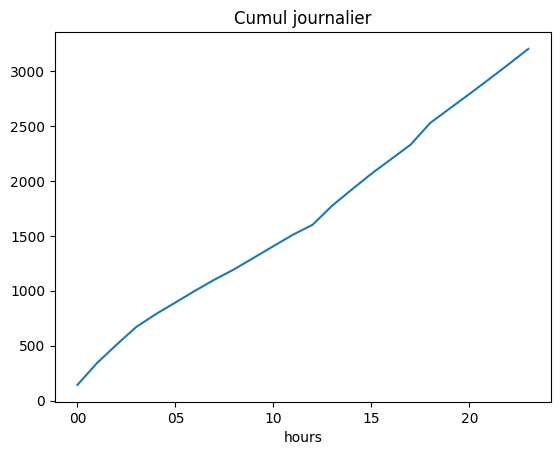

In [944]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

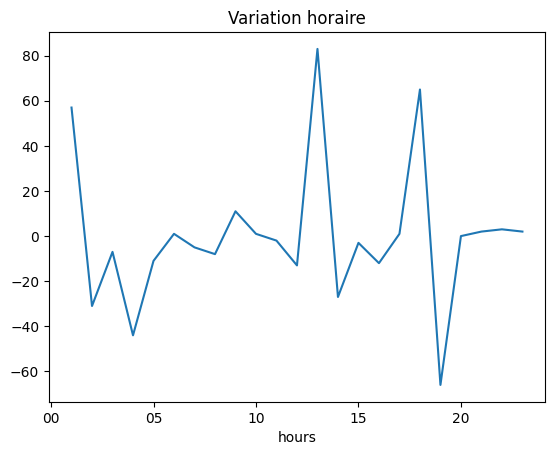

In [945]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [946]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

315

In [947]:
df_grp.tail(n)['kWh'].describe()


count    315.000000
mean       3.174603
std        0.735990
min        1.340000
25%        2.793500
50%        3.302000
75%        3.651500
max        4.786000
Name: kWh, dtype: float64

In [948]:
maxday = df_grp.tail(n)['kWh'].idxmax()

In [949]:
n, np.nanmean(df_grp.tail(n))

(315, np.float64(3.1746031746031744))

Text(0.5, 1.0, '315 days')

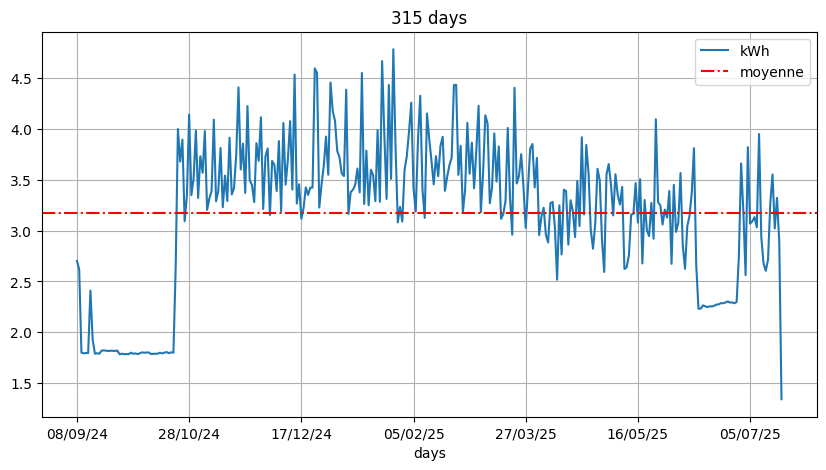

In [950]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

Text(0.5, 1.0, '100 days')

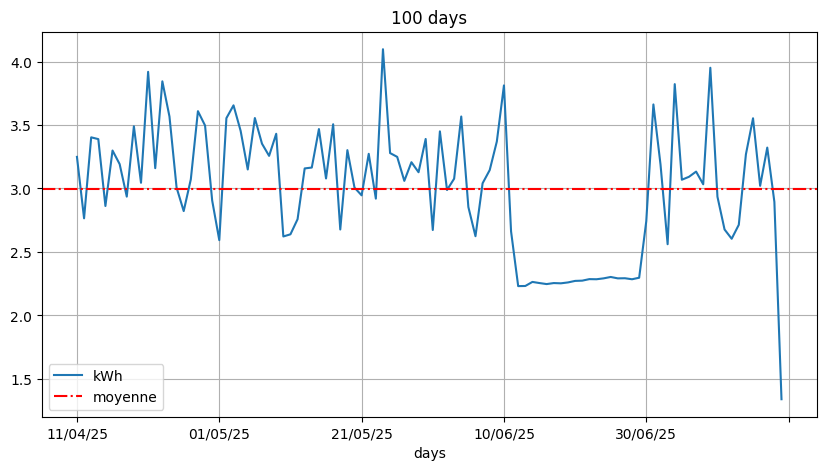

In [951]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

In [952]:
np.nanmean(df_grp.tail(span))

np.float64(2.99687)

In [953]:
df_grp['kWh']

days
08/09/24    2.701
09/09/24    2.618
10/09/24    1.799
11/09/24    1.791
12/09/24    1.796
            ...  
15/07/25    3.553
16/07/25    3.021
17/07/25    3.322
18/07/25    2.894
19/07/25    1.340
Name: kWh, Length: 315, dtype: float64

In [954]:
df_grp.describe()

,kWh
count,315.000000
mean,3.174603
std,0.735990
min,1.340000
25%,2.793500
50%,3.302000
75%,3.651500
max,4.786000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

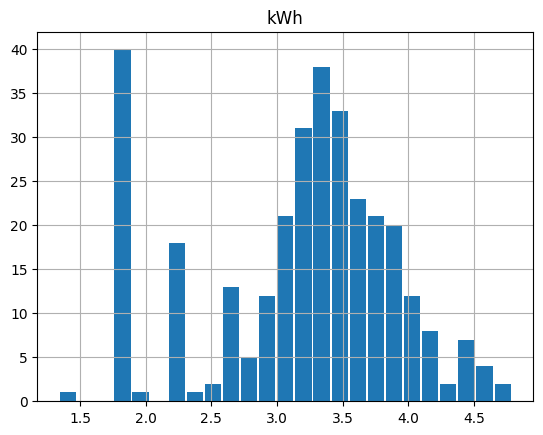

In [955]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [956]:
df_grp.tail(span)['kWh']

days
11/04/25    3.249
12/04/25    2.765
13/04/25    3.403
14/04/25    3.389
15/04/25    2.862
            ...  
15/07/25    3.553
16/07/25    3.021
17/07/25    3.322
18/07/25    2.894
19/07/25    1.340
Name: kWh, Length: 100, dtype: float64

# Conso par heure

In [957]:
day

'19/07/25'

In [958]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,103,103,NaN
01,98,201,-5.0
02,109,310,11.0
03,99,409,-10.0
04,99,508,0.0
05,100,608,1.0
06,125,733,25.0
07,124,857,-1.0
08,103,960,-21.0


In [959]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


12

In [960]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 13)

In [961]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [962]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

In [963]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
Name: days, dtype: float64

In [964]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [965]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 00 to 11
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     12 non-null     int64  
 1   cumsum  12 non-null     int64  
 2   diff    11 non-null     float64
 3   days    12 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 480.0+ bytes


In [966]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
Name: days, dtype: float64

In [967]:
day

'19/07/25'

In [968]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,103,103,NaN,1.0
01,98,201,-5.0,2.0
02,109,310,11.0,3.0
03,99,409,-10.0,4.0
04,99,508,0.0,5.0
05,100,608,1.0,6.0
06,125,733,25.0,7.0
07,124,857,-1.0,8.0
08,103,960,-21.0,9.0


In [969]:
kwh = grp_by_dayhours.loc[day][['kWh']]/1000
np.sum(kwh)[0]


c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\jeand\AppData\Local\Temp\ipykernel_11012\2885532441.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.sum(kwh)[0]


np.float64(1.3399999999999999)

In [970]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
08/09/24 03      12      12    NaN   NaN
         04     151     163  139.0   NaN
         05     214     377   63.0   NaN
         06     172     549  -42.0   NaN
         07     153     702  -19.0   NaN
...             ...     ...    ...   ...
19/07/25 07     124     857   -1.0   8.0
         08     103     960  -21.0   9.0
         09     105    1065    2.0  10.0
         10     156    1221   51.0  11.0
         11     119    1340  -37.0  12.0

[7545 rows x 4 columns]

c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, '19/07/25: kWh    1.34\ndtype: float64')

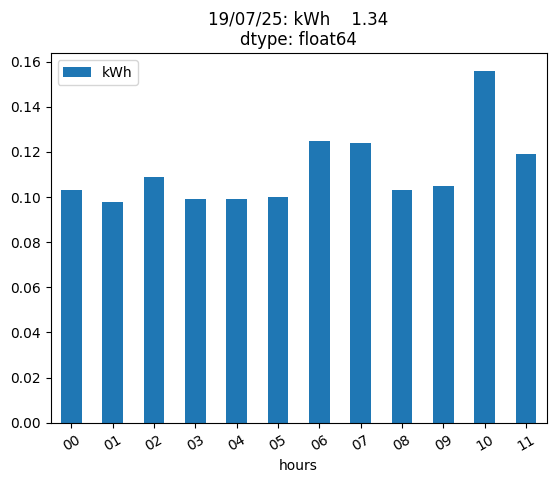

In [971]:
kwh.plot.bar(label='watt')
plt.legend()
plt.xticks(rotation=30)
plt.title(f'{day}: {np.sum(kwh)}')

In [972]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11'], dtype='object', name='hours')

# Conso du jour


In [973]:
grp_by_dayhours.count()

kWh       7545
cumsum    7545
diff      7230
days        12
dtype: int64

'27/01/25'

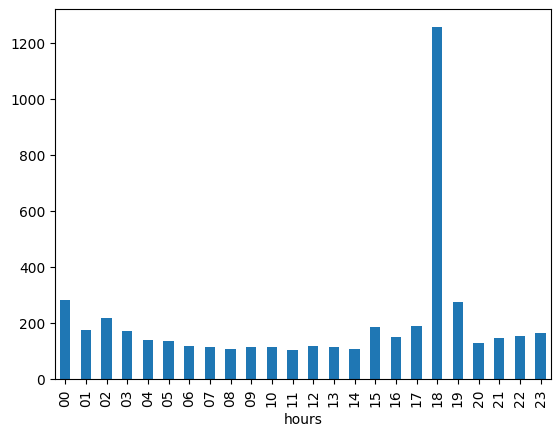

In [974]:
#day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh.plot(kind='bar')
maxday

In [975]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

Total= 299.687 , Moyenne= 2.99687


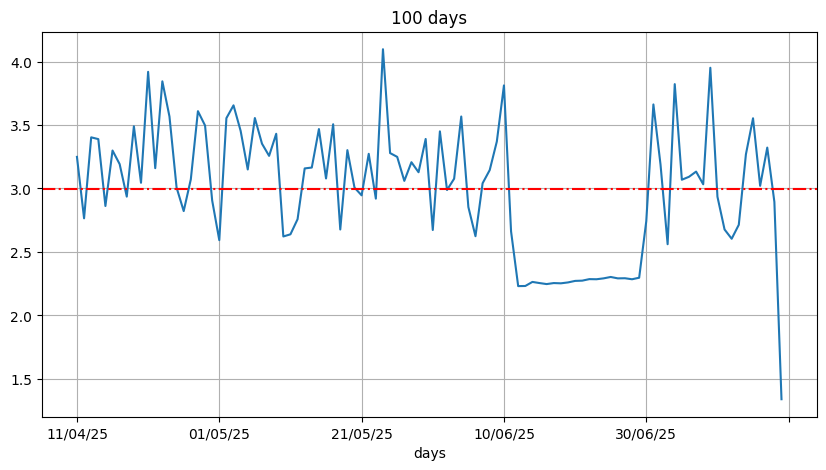

In [976]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

print('Total=',sum(df_grp.tail(span)['kWh']),', Moyenne=',np.nanmean(df_grp.tail(span)))

In [977]:
from datetime import datetime

# Get the current time
current_time = datetime.now()

# Convert the time to minutes in a day
minutes_in_day = current_time.hour * 60 + current_time.minute
print(f"Current time: {current_time.strftime('%H:%M:%S')}, Minutes in day: {minutes_in_day}")

Current time: 11:52:37, Minutes in day: 712


In [978]:
def convert_to_min_sec(seconds):
    """
    Convert a float value in seconds to minutes and seconds.
    """
    minutes, sec = divmod(seconds, 60)
    return f'{int(minutes)}:{round(sec, 2)}'


In [979]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(convert_to_min_sec(end - start))

1:50.27


In [980]:
end - start

110.26963448524475

In [981]:
#df = conso_day
show_tranches()

2
2025-07-19 00:00:03.941341	2025-07-19 09:19:21.135341	9h 19m 17s 	1000
2025-07-19 09:19:21.135341	2025-07-19 11:50:54.296341	2h 31m 33s 	340


In [982]:
df_grp.tail(7)['kWh']

days
13/07/25    2.714
14/07/25    3.269
15/07/25    3.553
16/07/25    3.021
17/07/25    3.322
18/07/25    2.894
19/07/25    1.340
Name: kWh, dtype: float64

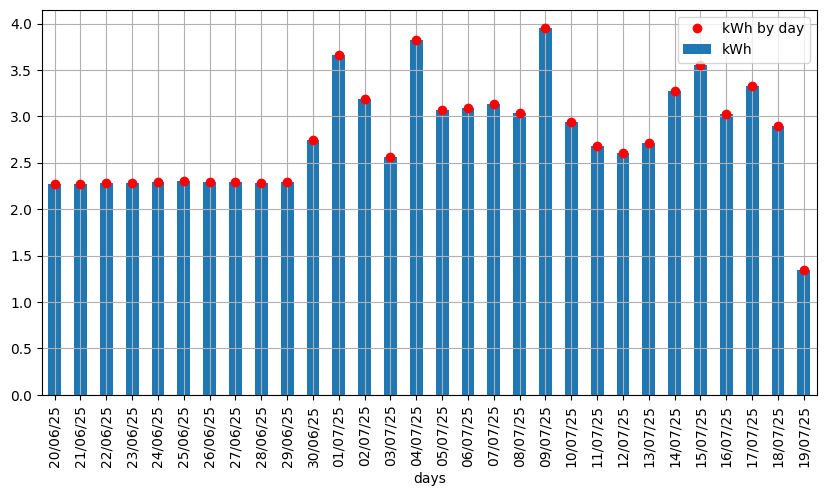

In [983]:
df_grp.tail(30)['kWh'].plot(figsize=(10, 5), kind='bar', layout='tight', grid=True)
plt.plot(df_grp.tail(30)['kWh'], 'ro', label='kWh by day')
plt.legend()

# Today

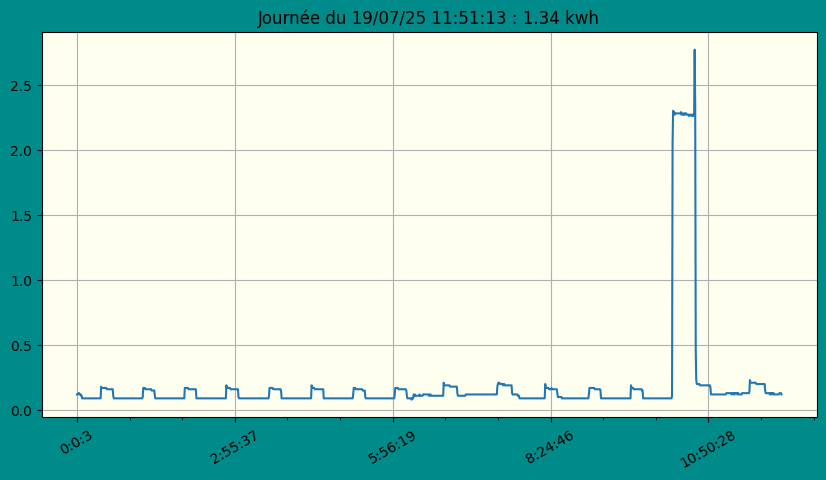

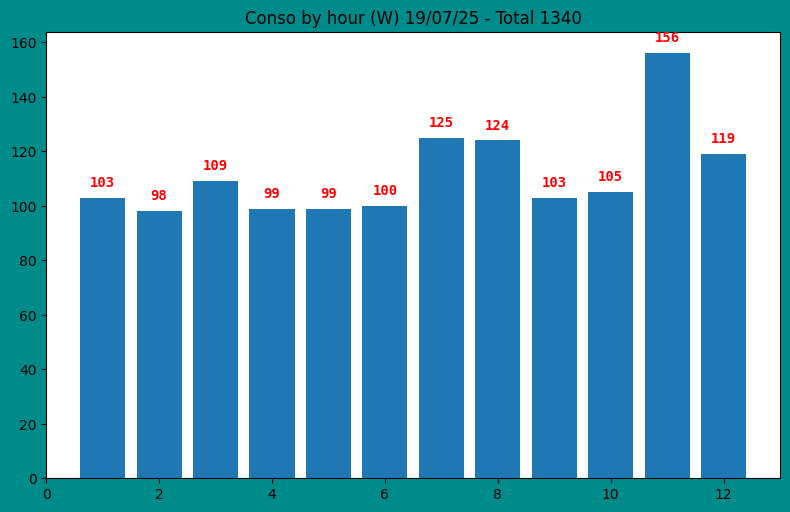

In [984]:
show(today,bgcolor='ivory')
conso_by_hour(today)

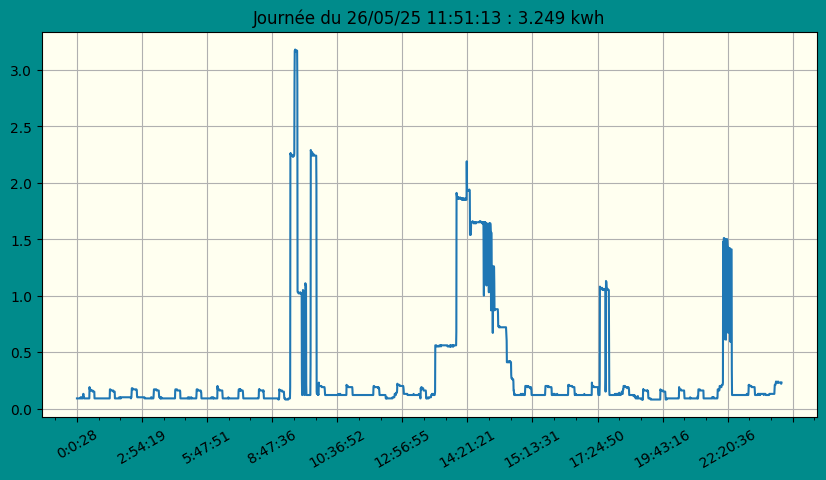

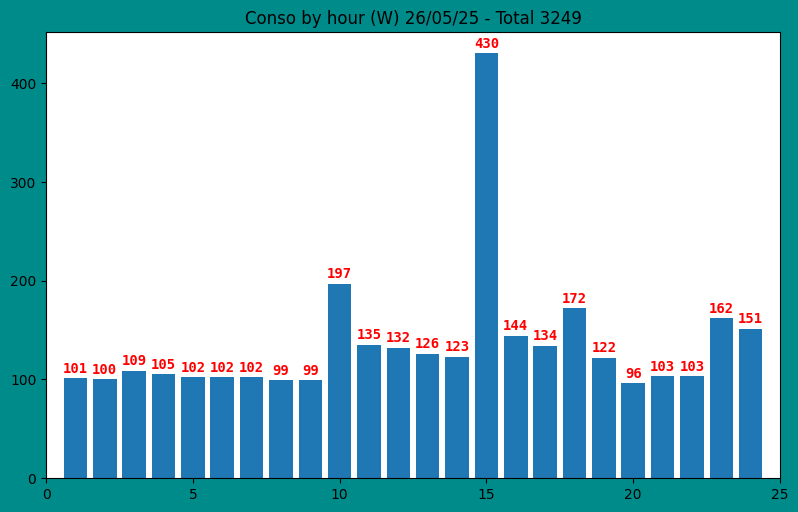

In [985]:
# 21/04/25 cuisine midi et télé le soir 4.115 kWh
day = '26/05/25' 
day, show(day,bgcolor='ivory')
conso_by_hour(day)

27/01/25


(None, 4786)

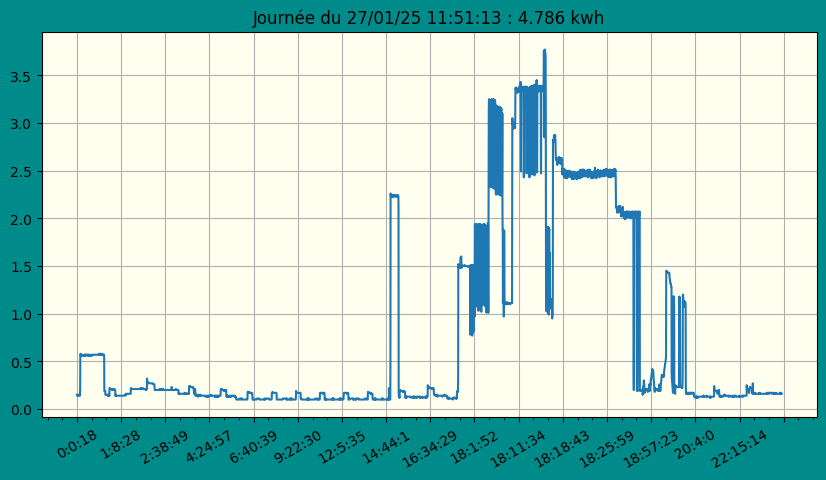

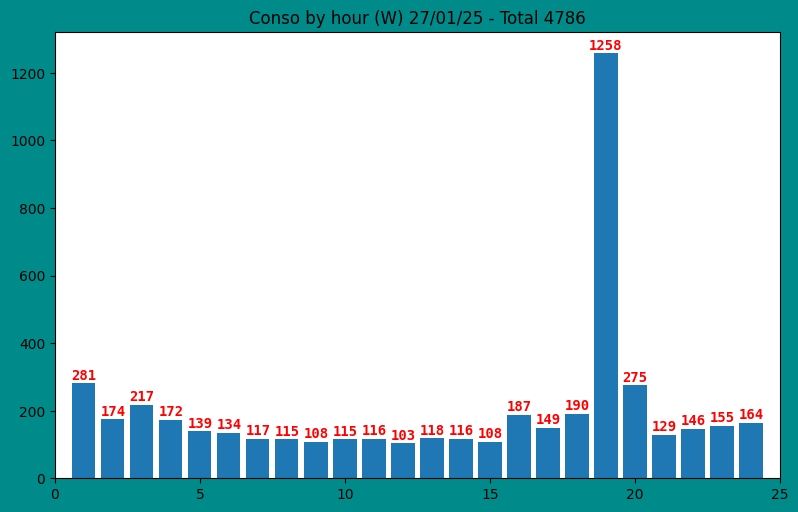

In [986]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

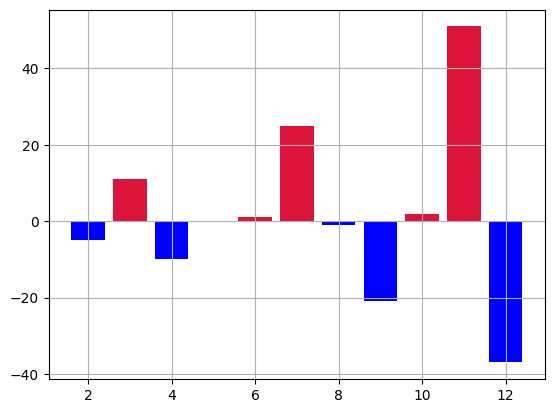

In [987]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

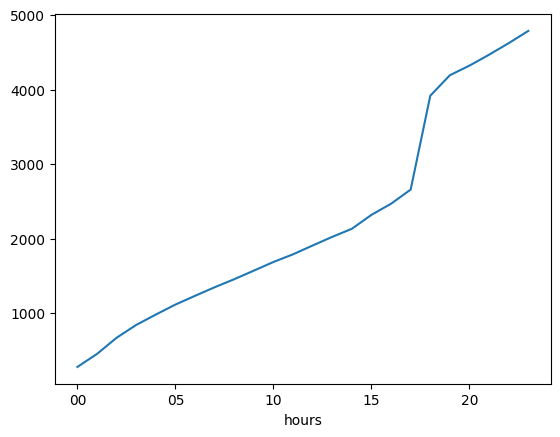

In [988]:
data.cumsum().plot()


<Axes: xlabel='hours'>

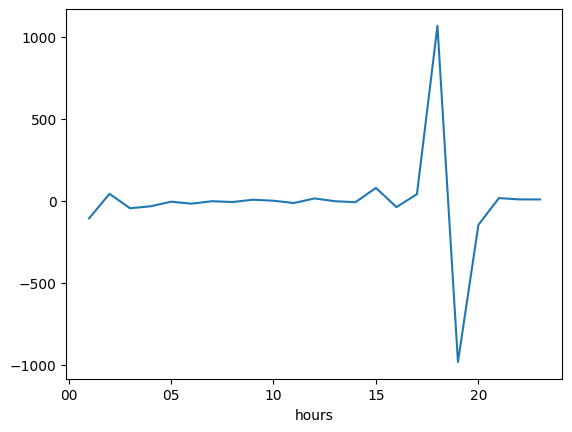

In [989]:
# evolution par heure
data.diff().plot()

In [990]:
data.diff().describe()

count      23.000000
mean       -5.086957
std       312.958161
min      -983.000000
25%       -25.000000
50%        -2.000000
75%        12.000000
max      1068.000000
Name: kWh, dtype: float64

<Axes: >

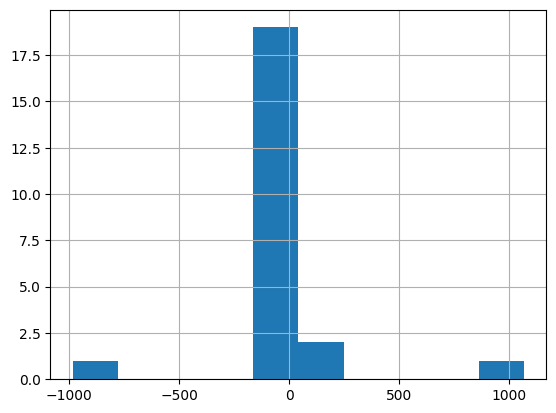

In [991]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [992]:
import os
os.listdir(path='.')

['.git',
 '.gitignore',
 '.git_old',
 '.ipynb_checkpoints',
 '.vs',
 '1row.flf',
 '5days_meteo.png',
 '5_days_meteo.ipynb',
 '7days_temp.png',
 '8days.csv',
 '8days.pkl',
 '8days_dump.json',
 '8days_to_json.json',
 'advanced_expression.ipynb',
 'almanac_sun_position.ipynb',
 'alphabeta_tree.ipynb',
 'amlich.ipynb',
 'amlich5.ipynb',
 'amlich5_test.ipynb',
 'amlich_data.py',
 'amlich_functions.py',
 'amlich_lib.py',
 'amlich_soc_tiet.ipynb',
 'AntPath.ipynb',
 'Apple.csv',
 'astronomie_def.ipynb',
 'atom_electronic_configuration.ipynb',
 'average_binding_energy_by_nucleons.ipynb',
 'bar_label.ipynb',
 'bell_curve.ipynb',
 'bitcoin_api.ipynb',
 'bitmap_convert.ipynb',
 'bitmap_structure.ipynb',
 'CAC40.csv',
 'celestial_waltz_paris_20250604.png',
 'celestial_waltz_paris_20250605.png',
 'celestial_waltz_paris_20250606.png',
 'celestial_waltz_paris_20250608.png',
 'celestial_waltz_paris_20250609.png',
 'celestial_waltz_paris_20250610.png',
 'celestial_waltz_paris_20250611.png',
 'chance-to

# list store files csv


In [993]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

8days.csv
Apple.csv
CAC40.csv
conso_data.csv
conso_day_from_20230821.csv
conso_jour.csv
conso_par_jour.csv
data_temp16122022.csv
demain.csv
df.csv
df_grp.csv
DowJones.csv
EURUSD.csv
Ford.csv
karaoke.csv
ligue1_2020_27.csv
Nasdaq.csv
Nikkei.csv
planete.csv
saturn_bodies.csv
saturn_rings.csv
SMSSpamCollection.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
temp_humidity.csv
Tesla.csv
titanic.csv
Toyota.csv
VNDUSD.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
week.csv


('27/01/25', None)

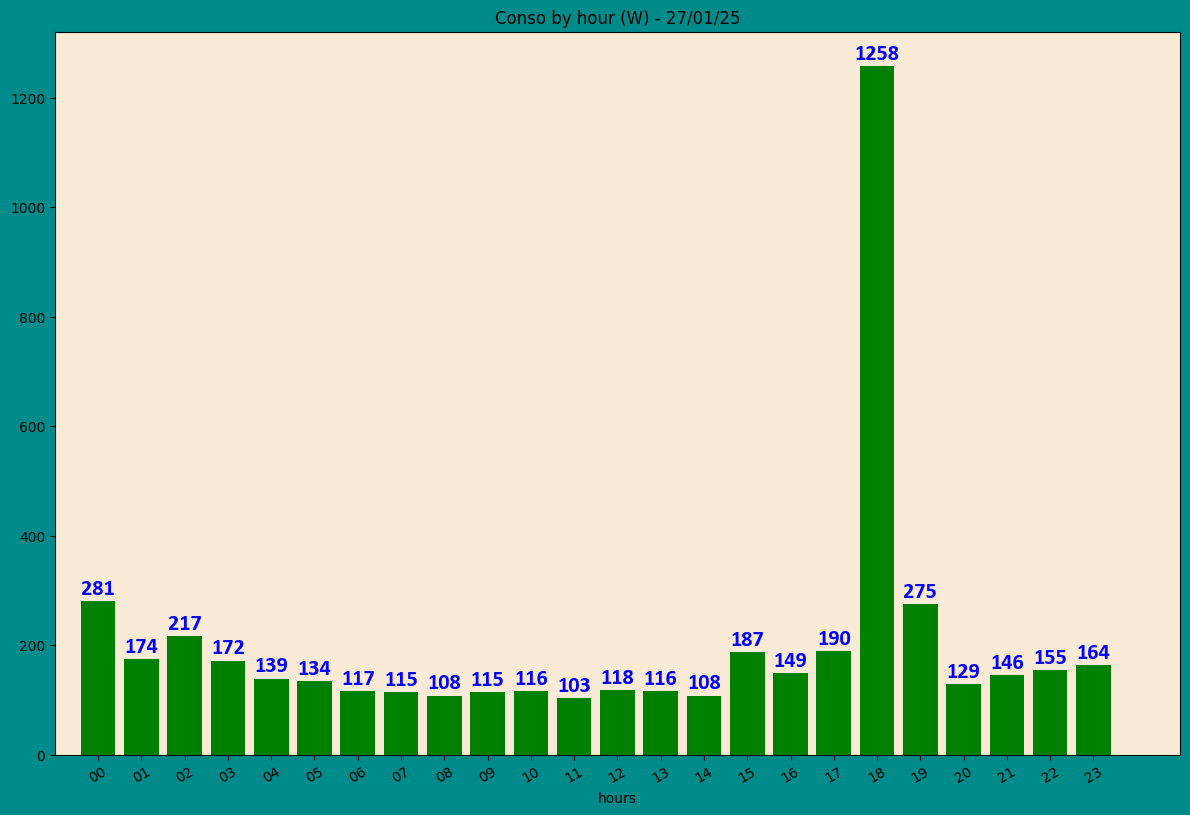

In [994]:
day,conso_byhour(day)

In [995]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


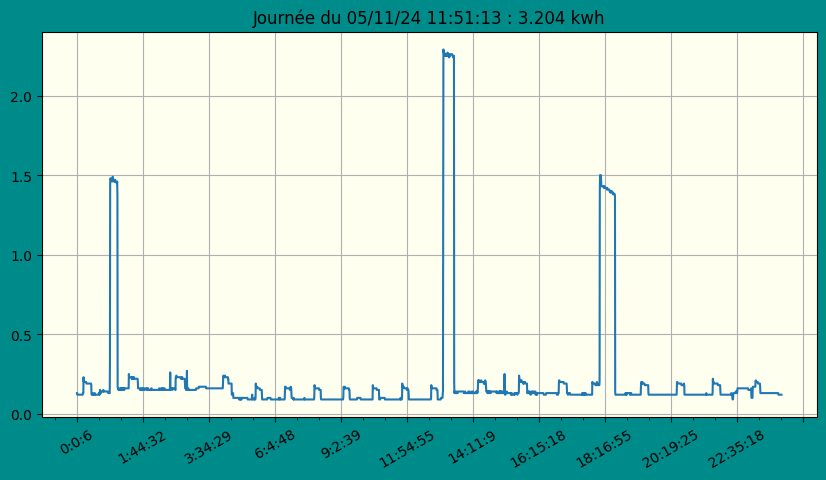

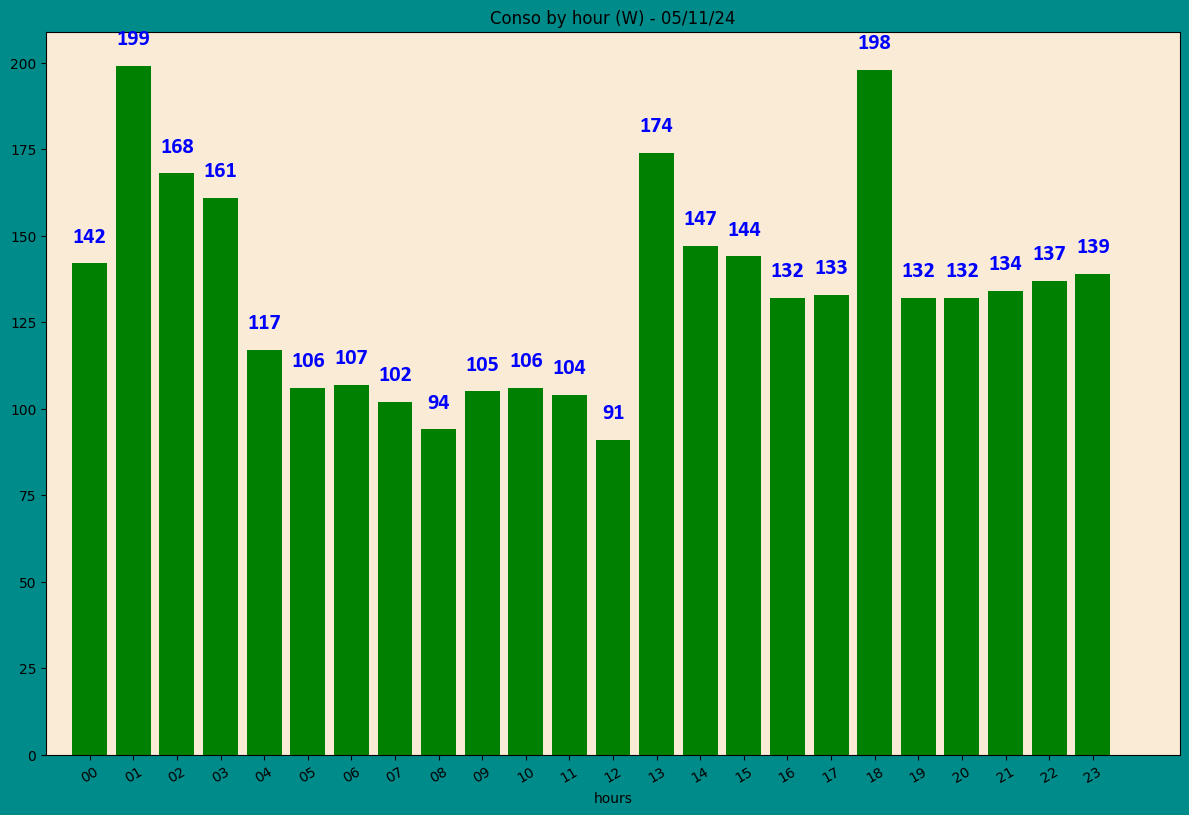

In [996]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [997]:
month

,day,hours,months,kWh
669331,01,00,2025-04,0.21
669332,01,00,2025-04,0.21
669333,01,00,2025-04,0.21
669334,01,00,2025-04,0.21
669335,01,00,2025-04,0.21
...,...,...,...,...
765340,30,23,2025-04,0.09
765341,30,23,2025-04,0.09
765342,30,23,2025-04,0.09
765343,30,23,2025-04,0.09


In [998]:
month.describe()


,kWh
count,96014.000000
mean,0.310189
std,0.547333
min,0.080000
25%,0.090000
50%,0.120000
75%,0.180000
max,3.790000


<Axes: >

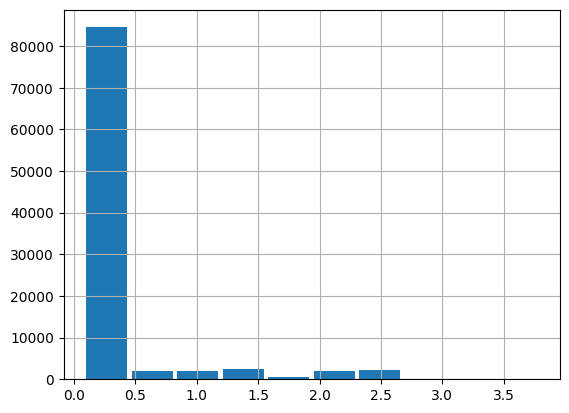

In [999]:
# bins of conso scale by hour
month['kWh'].hist(bins=10, density=False, histtype='bar',rwidth=0.9, align='mid')

<Axes: >

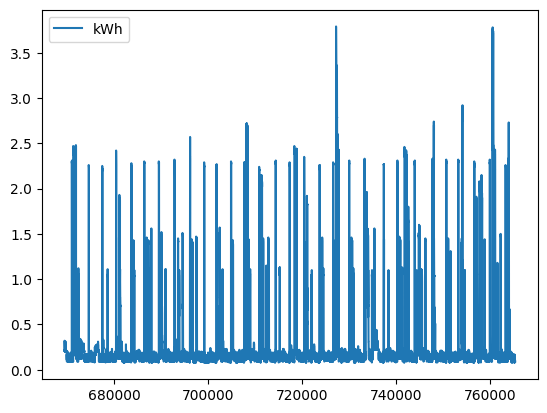

In [1000]:
month.plot()

In [1001]:
# index with max conso in this month
month.idxmax().kWh

np.int64(727206)

In [1002]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       762439
hours     672881
months    669331
kWh       727206
dtype: int64

In [1003]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [1004]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
08/09/24 03      12      12    NaN   NaN
         04     151     163  139.0   NaN
         05     214     377   63.0   NaN
         06     172     549  -42.0   NaN
         07     153     702  -19.0   NaN
...             ...     ...    ...   ...
19/07/25 07     124     857   -1.0   8.0
         08     103     960  -21.0   9.0
         09     105    1065    2.0  10.0
         10     156    1221   51.0  11.0
         11     119    1340  -37.0  12.0

[7545 rows x 4 columns]

In [1005]:
month

,day,hours,months,kWh
669331,01,00,2025-04,0.21
669332,01,00,2025-04,0.21
669333,01,00,2025-04,0.21
669334,01,00,2025-04,0.21
669335,01,00,2025-04,0.21
...,...,...,...,...
765340,30,23,2025-04,0.09
765341,30,23,2025-04,0.09
765342,30,23,2025-04,0.09
765343,30,23,2025-04,0.09


In [1006]:
month.idxmax()


day       762439
hours     672881
months    669331
kWh       727206
dtype: int64

In [1007]:
month.loc[month.idxmax().kWh]


day            19
hours          14
months    2025-04
kWh          3.79
Name: 727206, dtype: object

In [1008]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       179
          01       175
          02       173
          03       121
          04       114
          05       111
          06       109
          07       100
          08       111
          09       110
          10       107
          11       100
          12       168
          13       143
          14       146
          15       135
          16       203
          17       142
          18       152
          19       191
          20       150
          21       146
          22       143
          23       173
Name: kWh, dtype: int64

In [1009]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'16'

<Axes: xlabel='days,hours'>

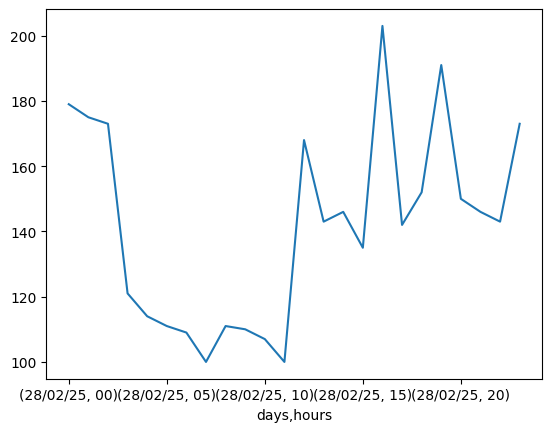

In [1010]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [1011]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [1012]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [1013]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [1014]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB